In [3]:
using Revise
includet("../../utils/IFMAB3.jl")
includet("../ModifiedShallowWater.jl")
using .RotatingShallowWater
using FourierFlows
using FourierFlows: radialspectrum
using Printf
using LinearAlgebra: mul!, ldiv!
using CairoMakie
using AbstractFFTs

In [4]:
function set_shafer_initial_condition!(prob, Kg, Kw, ag, aw, f, Cg2)
    grid = prob.grid
    dev = typeof(grid.device)
    T = typeof(grid.Lx)

    @devzeros dev Complex{T} (grid.nkr, grid.nl) ugh vgh ηgh uwh vwh ηwh
    @devzeros dev T (grid.nx, grid.ny) ug uw
    
    geo_filter  = Kg[1]^2 .<= grid.Krsq .<= Kg[2]^2
    wave_filter = Kw[1]^2 .<= grid.Krsq .<= Kw[2]^2
    phase = device_array(grid.device)(2π*rand(grid.nkr, grid.nl))
    sgn =  device_array(grid.device)(sign.(rand(grid.nkr, grid.nl) .- 0.5))
    shift = exp.(1im * phase)
    ηgh[geo_filter] += ( 0.5   * shift)[geo_filter]
    ugh[geo_filter] += (-0.5im * Cg2 / f * grid.l  .* shift)[geo_filter]
    vgh[geo_filter] += ( 0.5im * Cg2 / f * grid.kr .* shift)[geo_filter]

    ldiv!(ug, grid.rfftplan, deepcopy(ugh))
    ηgh *= ag / maximum(abs.(ug))
    ugh *= ag / maximum(abs.(ug))
    vgh *= ag / maximum(abs.(ug))

    ωK =  sgn .* sqrt.(f^2 .+ Cg2 * grid.Krsq)
    ηwh[wave_filter] += (0.5 * shift)[wave_filter]
    uwh[wave_filter] += (grid.invKrsq.*(0.5 * grid.kr .* ωK .* shift + 0.5im * f * grid.l  .* shift))[wave_filter]
    vwh[wave_filter] += (grid.invKrsq.*(0.5 * grid.l .*  ωK .* shift - 0.5im * f * grid.kr .* shift))[wave_filter]
    
    ldiv!(uw, grid.rfftplan, deepcopy(uwh))
    ηwh *= aw / maximum(abs.(uw))
    uwh *= aw / maximum(abs.(uw))
    vwh *= aw / maximum(abs.(uw))
    RotatingShallowWater.set_solution!(prob, ugh + uwh, vgh + vwh, ηgh + ηwh)
end

set_shafer_initial_condition! (generic function with 1 method)

In [67]:
dev = CPU()
Lx=2π
nx=512
dx=Lx/nx
kmax = nx/2 - 1
nν = 4
nsteps = 30000
nsubs = 300
#ν = 1.0e-16 * (nx)
cfltune = 0.05
ag = 0.3
aw = 0.05
umax = ag + aw
dt = cfltune / umax * dx
νtune = 1 / cfltune# 250000
ν = νtune * 2π / nx / (kmax^(2*nν)) / dt

prob = RotatingShallowWater.Problem(dev; Lx, nx, dt, f=3.0, T=Float32, nν, ν, aliased_fraction=1/3, order=8, tol=eps(Float32))
#qg_prob = SWQG.Problem(dev; Lx, nx, dt, f=3.0, T=Float32, nν, ν, aliased_fraction=1/3)
grid, clock, vars, params = prob.grid, prob.clock, prob.vars, prob.params

set_shafer_initial_condition!(prob, (10, 13), (0, 5), ag, aw, params.f, params.Cg2)

In [70]:
for i=1:50
    RotatingShallowWater.stepforward!(prob, [], 250)
    RotatingShallowWater.updatevars!(prob)
    max_u = max(maximum(prob.vars.u), maximum(prob.vars.v))
    println(@sprintf("t = %0.3f, max |u|=%0.2e, cfl=%0.2e", clock.t, max_u, max_u * dx / dt))
end

t = 22.351, max |u|=3.02e-01, cfl=2.11e+00
t = 22.789, max |u|=3.29e-01, cfl=2.30e+00
t = 23.227, max |u|=3.09e-01, cfl=2.16e+00
t = 23.665, max |u|=2.96e-01, cfl=2.07e+00
t = 24.103, max |u|=3.10e-01, cfl=2.17e+00
t = 24.542, max |u|=3.04e-01, cfl=2.13e+00
t = 24.980, max |u|=3.34e-01, cfl=2.34e+00
t = 25.418, max |u|=3.57e-01, cfl=2.50e+00
t = 25.856, max |u|=3.08e-01, cfl=2.15e+00
t = 26.294, max |u|=2.92e-01, cfl=2.05e+00
t = 26.733, max |u|=3.29e-01, cfl=2.30e+00
t = 27.171, max |u|=3.14e-01, cfl=2.20e+00
t = 27.609, max |u|=2.97e-01, cfl=2.08e+00
t = 28.047, max |u|=3.32e-01, cfl=2.32e+00
t = 28.486, max |u|=3.00e-01, cfl=2.10e+00
t = 28.924, max |u|=3.00e-01, cfl=2.10e+00
t = 29.362, max |u|=2.77e-01, cfl=1.94e+00
t = 29.800, max |u|=2.75e-01, cfl=1.93e+00
t = 30.238, max |u|=2.82e-01, cfl=1.97e+00
t = 30.677, max |u|=3.03e-01, cfl=2.12e+00
t = 31.115, max |u|=2.91e-01, cfl=2.04e+00
t = 31.553, max |u|=2.76e-01, cfl=1.93e+00
t = 31.991, max |u|=2.94e-01, cfl=2.06e+00
t = 32.430,

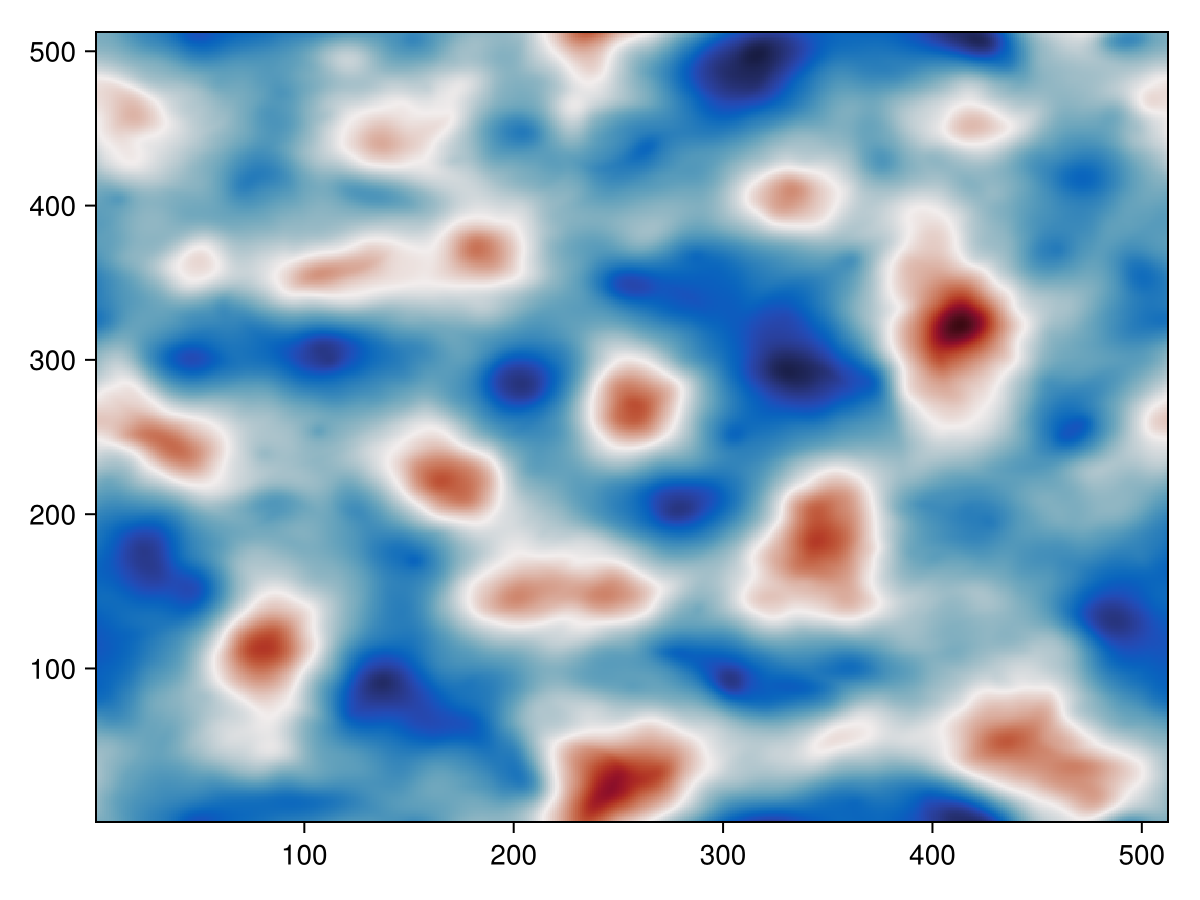

In [94]:
divh = 1im * (grid.kr .* prob.vars.uh + grid.l .* prob.vars.vh)
div = irfft(divh, grid.nx)
#heatmap(sqrt.(prob.vars.u.^2 + prob.vars.v.^2), colormap=:amp)
heatmap(prob.vars.η, colormap=:balance)

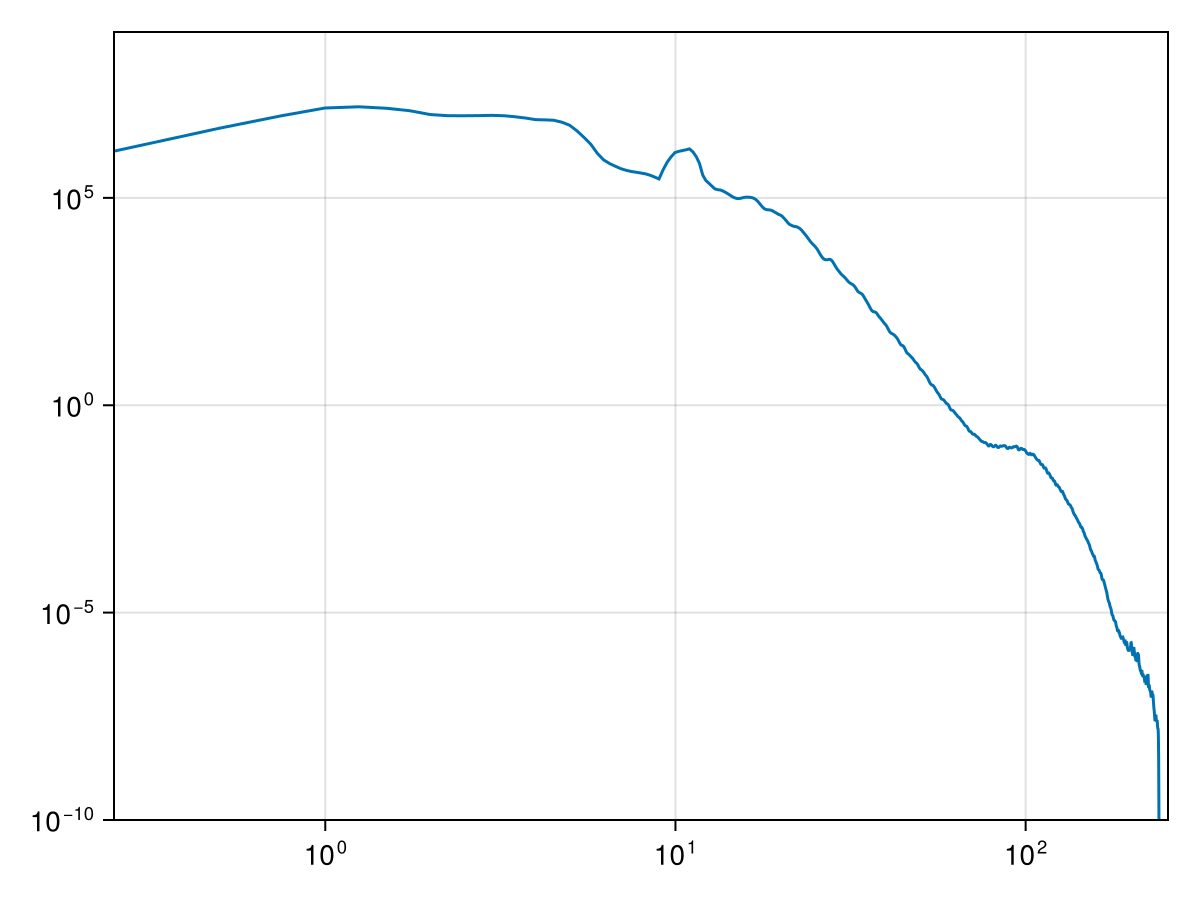

In [92]:
include("../../rsw/RSWUtils.jl")
((ugh, vgh, ηgh), (uwh, vwh, ηwh)) = wave_balanced_decomposition(prob)
ρ, KEh = FourierFlows.radialspectrum(abs2.(uwh) + abs2.(vwh), grid)
lines(ρ, KEh[:]; axis=(;xscale=log10, yscale=log10, limits=((ρ[2], ρ[end]), (1e-10, 1e9))))

ν = 1.6780303489894543e-18
dt = 0.00409061543436171
|u| = 0.32619566
|ζ| = 4.73945
|η| = 0.07320997
|D| = 495.26715
expLdt is nan = false
|expLdt| = 0.07184223
cfl = 0.10873188575108847


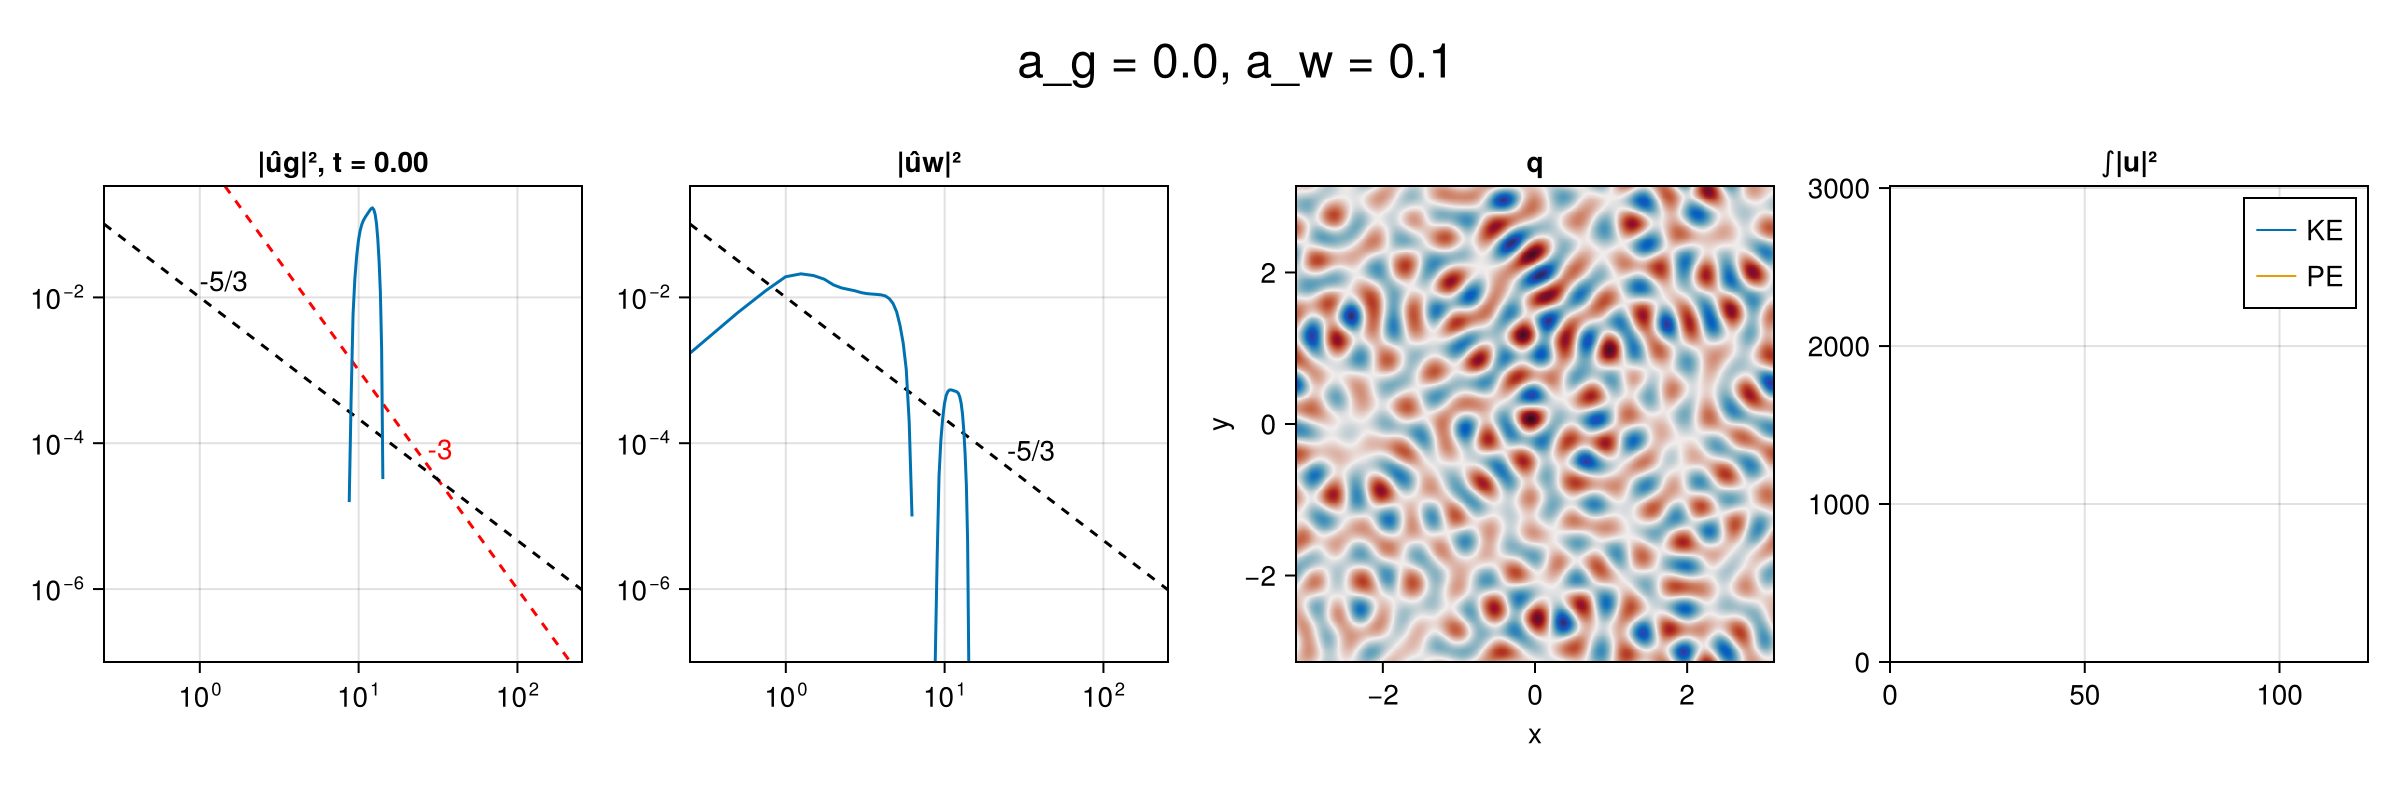

In [13]:
Lx, Ly = grid.Lx, grid.Ly
x, y = grid.x, grid.y

rswE = Diagnostic(energy, prob; nsteps, freq=1)
diags = [rswE]

title_KEg = Observable(@sprintf("|ûg|², t = %.2f", clock.t))
title_KEw = Observable(@sprintf("|ûw|²"))
title_ζ = "q"
title_E = "∫|u|²"

fig = Figure(size=(1200, 400))
Label(fig[0, 1:4], text = "a_g = 0.0, a_w = 0.1", fontsize = 24)

axis_kwargs = (xlabel = "x",
               ylabel = "y",
               aspect = 1,
               limits = ((-Lx/2, Lx/2), (-Ly/2, Ly/2)))


wave_geo_decomp = Observable(wave_balanced_decomposition(prob))

u = Observable(Array(vars.u))
v = Observable(Array(vars.v))
uh = Observable(Array(vars.uh))
vh = Observable(Array(vars.vh))
ζ = Observable(Array(vars.ζ))
η = Observable(Array(vars.η))
ugh = @lift(Array($wave_geo_decomp[1][1]))
vgh = @lift(Array($wave_geo_decomp[1][2]))
uwh = @lift(Array($wave_geo_decomp[2][1]))
vwh = @lift(Array($wave_geo_decomp[2][2]))

ζ_max = @lift(maximum(abs.($ζ)))
#U_max = @lift(max(maximum(abs.($u)), maximum(abs.($v)), sqrt(params.Cg2 + params.f^2)))
U_max = @lift(max(maximum(abs.($u)), maximum(abs.($v))))
η_max = @lift(maximum(abs.($η)))

ρgEgρ = @lift(radialspectrum(grid.dx^2/grid.nx^2 * (abs2.($ugh) + abs2.($vgh)), grid))
ρg = @lift($ρgEgρ[1])
Egρ = @lift(replace($ρgEgρ[2][:], 0.0=>NaN))
Eg_max = @lift(maximum(abs.($ρgEgρ[2])))
Eg_min = @lift(max(minimum(abs.($ρgEgρ[2])), 1e-7))

ρwEwρ = @lift(radialspectrum(grid.dx^2/grid.nx^2 * (abs2.($uwh) + abs2.($vwh)), grid))
ρw = @lift($ρwEwρ[1])
Ewρ = @lift(replace($ρwEwρ[2][:], 0.0=>NaN))
Ew_max = @lift(maximum(abs.($ρwEwρ[2])))
Ew_min = @lift(max(minimum(abs.($ρwEwρ[2])), 1e-7))

E_min = @lift(min($Ew_min, $Eg_min))
E_max = @lift(max($Ew_max, $Eg_max))

ax_KEg = Axis(fig[1, 1]; title = title_KEg, xscale=log10, yscale=log10, limits=((ρg[][2], ρg[][end]), (E_min[], E_max[])), aspect=1)
ax_KEw = Axis(fig[1, 2]; title = title_KEw, xscale=log10, yscale=log10, limits=((ρg[][2], ρg[][end]), (E_min[], E_max[])), aspect=1)
axζ = Axis(fig[1, 3]; title = title_ζ, axis_kwargs...)
axE = Axis(fig[1, 4]; title = title_E, limits=((0, nsteps*dt), (0, 2*(rswE.data[1][1] + rswE.data[1][2]))), aspect=1)

KE = Observable(Point2f[(rswE.t[1], rswE.data[1][1])])
PE = Observable(Point2f[(rswE.t[1], rswE.data[1][2])])

lines!(ax_KEg, ρg[], 1e0*ρg[].^(-3.00), linestyle=:dash, color=:red, label="-3")
text!(ax_KEg, ρg[][110], 1e0*ρg[][110].^(-3.00), text="-3", color=:red)
lines!(ax_KEg, ρg[], 1e-2*ρg[].^(-5/3), linestyle=:dash, color=:black, label="-5/3")
text!(ax_KEg, ρg[][5], 1e-2*ρg[][5].^(-5/3), text="-5/3", color=:black)
lines!(ax_KEg, ρg, Egρ)

lines!(ax_KEw, ρw[], 1e-2*ρw[].^(-5/3), linestyle=:dash, color=:black, label="-5/3")
text!(ax_KEw, ρw[][100], 1e-2*ρw[][100].^(-5/3), text="-5/3", color=:black)
lines!(ax_KEw, ρw, Ewρ)

ax_KEg.limits = ((ρg[][2], ρg[][end]), (E_min[], 2*E_max[]))
ax_KEw.limits = ((ρg[][2], ρg[][end]), (E_min[], 2*E_max[]))
hmζ = heatmap!(axζ, x, y, ζ; colormap = :balance)
@lift hmζ.colorrange = (-$ζ_max, $ζ_max)
ke_line = lines!(axE, KE; linewidth = 1)
pe_line = lines!(axE, PE; linewidth = 1)
axislegend(axE, [ke_line, pe_line], ["KE", "PE"])
#hmη = heatmap!(axη, x, y, η; colormap = :balance)
#@lift hmη.colorrange = (-$η_max, $η_max)

println("ν = ", ν)
println("dt = ", dt)
println("|u| = ", U_max[])
println("|ζ| = ", ζ_max[])
println("|η| = ", η_max[])
println("|D| = ", maximum(abs.(prob.eqn.L[:,:,1,1])))
println("expLdt is nan = ", any(isnan, prob.timestepper.expLdt))
println("|expLdt| = ", minimum(real.(prob.timestepper.expLdt[:,:,2,2])))
println("cfl = ", dt / dx * U_max[])
fig

In [85]:
RotatingShallowWater.enforce_reality_condition!(prob)
frames = 0:round(Int, nsteps / nsubs)

starttime = time()
CairoMakie.record(fig, "shallow_water.mp4", frames, framerate = 12) do frame
    u[] = vars.u
    uh[] = vars.uh
    vh[] = vars.vh
    ζ[] = vars.ζ
    η[] = vars.η
    title_KEg[] = @sprintf("|ûg|², t = %.2f", clock.t)
    KE[] = push!(KE[], Point2f(rswE.t[rswE.i], rswE.data[rswE.i][1]))
    PE[] = push!(PE[], Point2f(rswE.t[rswE.i], rswE.data[rswE.i][2]))
    wave_geo_decomp[] = wave_balanced_decomposition(prob)
    if (frame % 100 == 0)
        max_udx = max(maximum(abs.(vars.u)) / grid.dx, maximum(abs.(vars.v)) / grid.dy)
        cfl = clock.dt * max_udx
        println(@sprintf("step: %04d, t: %.2f, cfl: %.2e, time: %.2f mins", clock.step, clock.t, cfl, (time() - starttime) / 60))
        flush(stdout)
    end
    RotatingShallowWater.stepforward!(prob, diags, nsubs)
    if(any(isnan.(vars.η)))
        println("Blew up at step ", clock.step)
        throw("Solution is NaN")
    end
    RotatingShallowWater.updatevars!(prob)
end

step: 0000, t: 0.00, cfl: 1.19e-01, time: 0.00 mins
step: 30000, t: 122.69, cfl: 9.89e-02, time: 0.86 mins


"shallow_water.mp4"

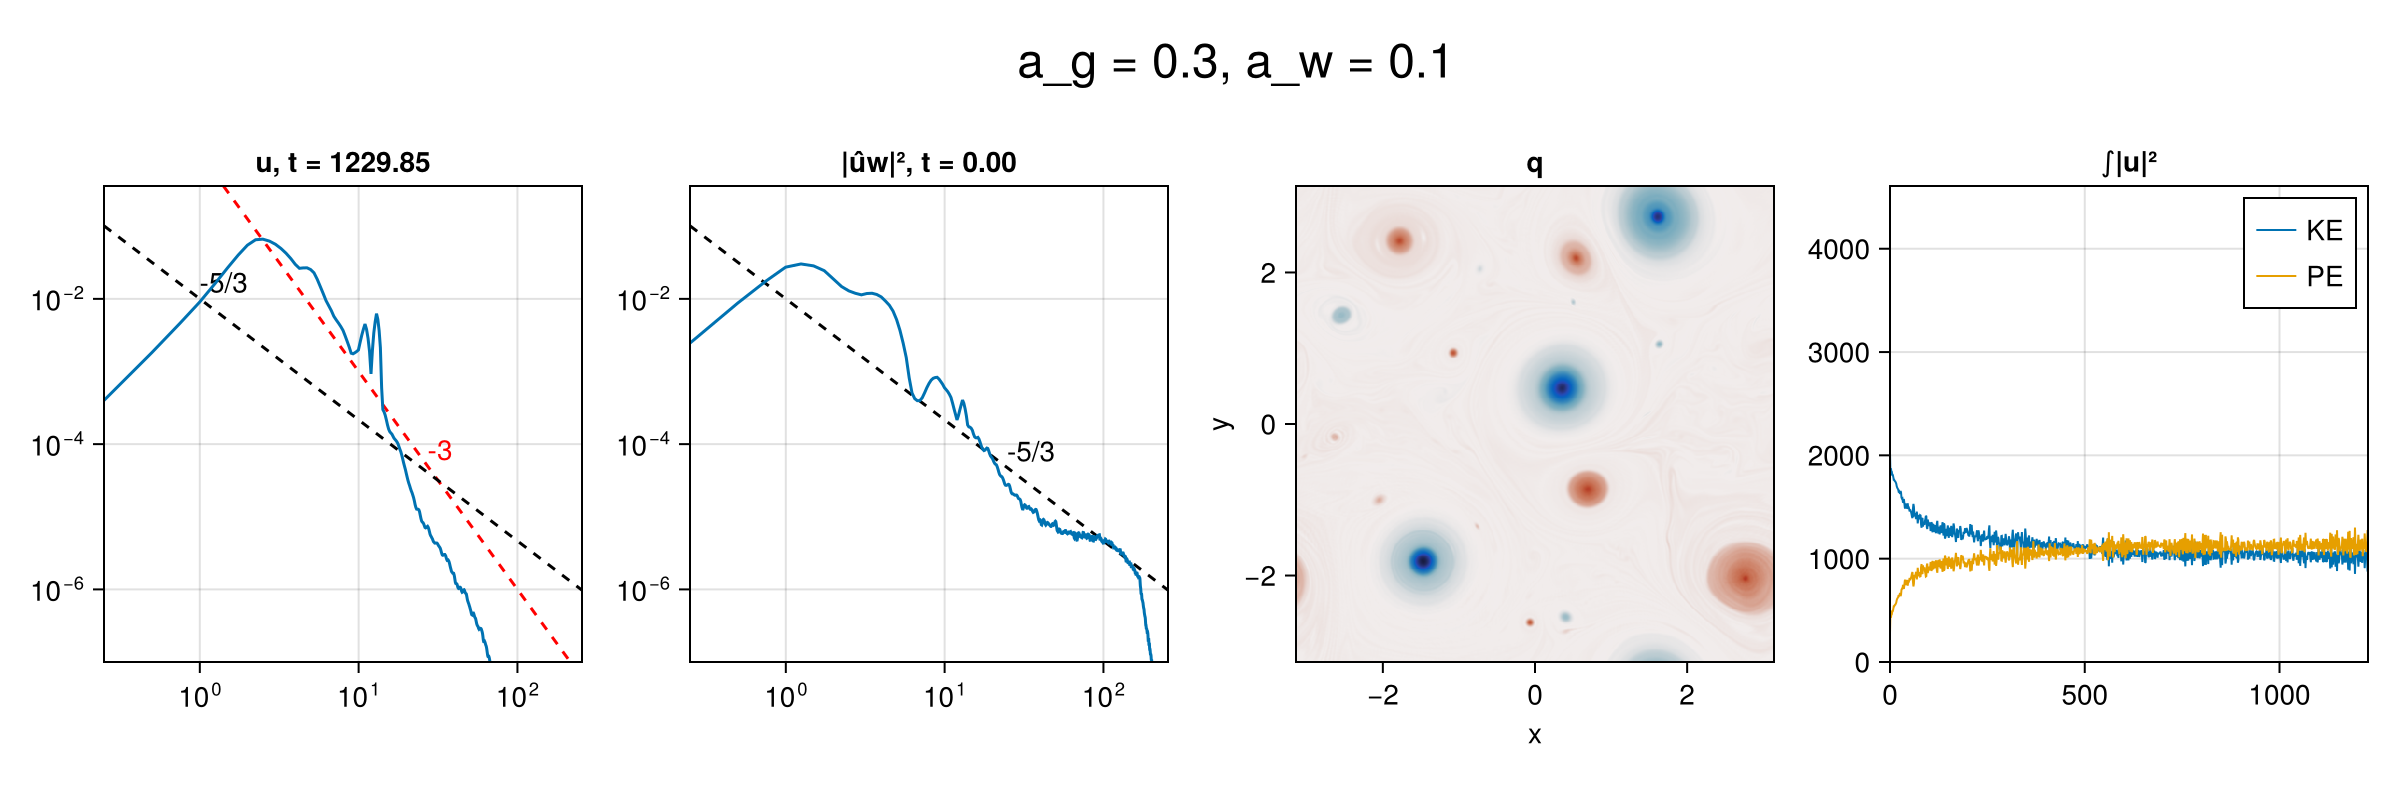

In [38]:
fig

((ComplexF32[0.0f0 + 0.0f0im -423.5664f0 - 123.416336f0im … -834.32227f0 + 32.647987f0im -423.57074f0 + 123.42271f0im; -0.0f0 + 0.0f0im -128.34032f0 + 188.78497f0im … -909.8615f0 + 1209.4894f0im -437.9675f0 - 382.83057f0im; … ; -0.0f0 + 0.0f0im -0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; -0.0f0 + 0.0f0im -0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im], ComplexF32[-0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 336.06476f0 - 58.229713f0im 128.34032f0 - 188.78497f0im … -454.93076f0 + 604.7447f0im -437.9675f0 - 382.83057f0im; … ; 0.0f0 - 0.0f0im 0.0f0 - 0.0f0im … 0.0f0 - 0.0f0im 0.0f0 - 0.0f0im; 0.0f0 - 0.0f0im 0.0f0 - 0.0f0im … 0.0f0 - 0.0f0im 0.0f0 - 0.0f0im], ComplexF32[-1495.1774f0 + 1360.1561f0im 370.24902f0 - 1270.6992f0im … 48.97198f0 + 1251.4834f0im 370.26813f0 + 1270.7122f0im; -174.68915f0 - 1008.1943f0im -566.3549f0 - 385.02094f0im … 1814.2341f0 + 1364.7922f0im -1148.4917f0 + 1313.9025f0im; … ; -0.0f0 - 0.0f0im -0.0f0 - 0.0f0im … -0.0f0 - 0.0f0im 

(0.0:0.24926685523360578:254.99999290397872, [0.0; 0.0; … ; 0.0; 0.0;;])

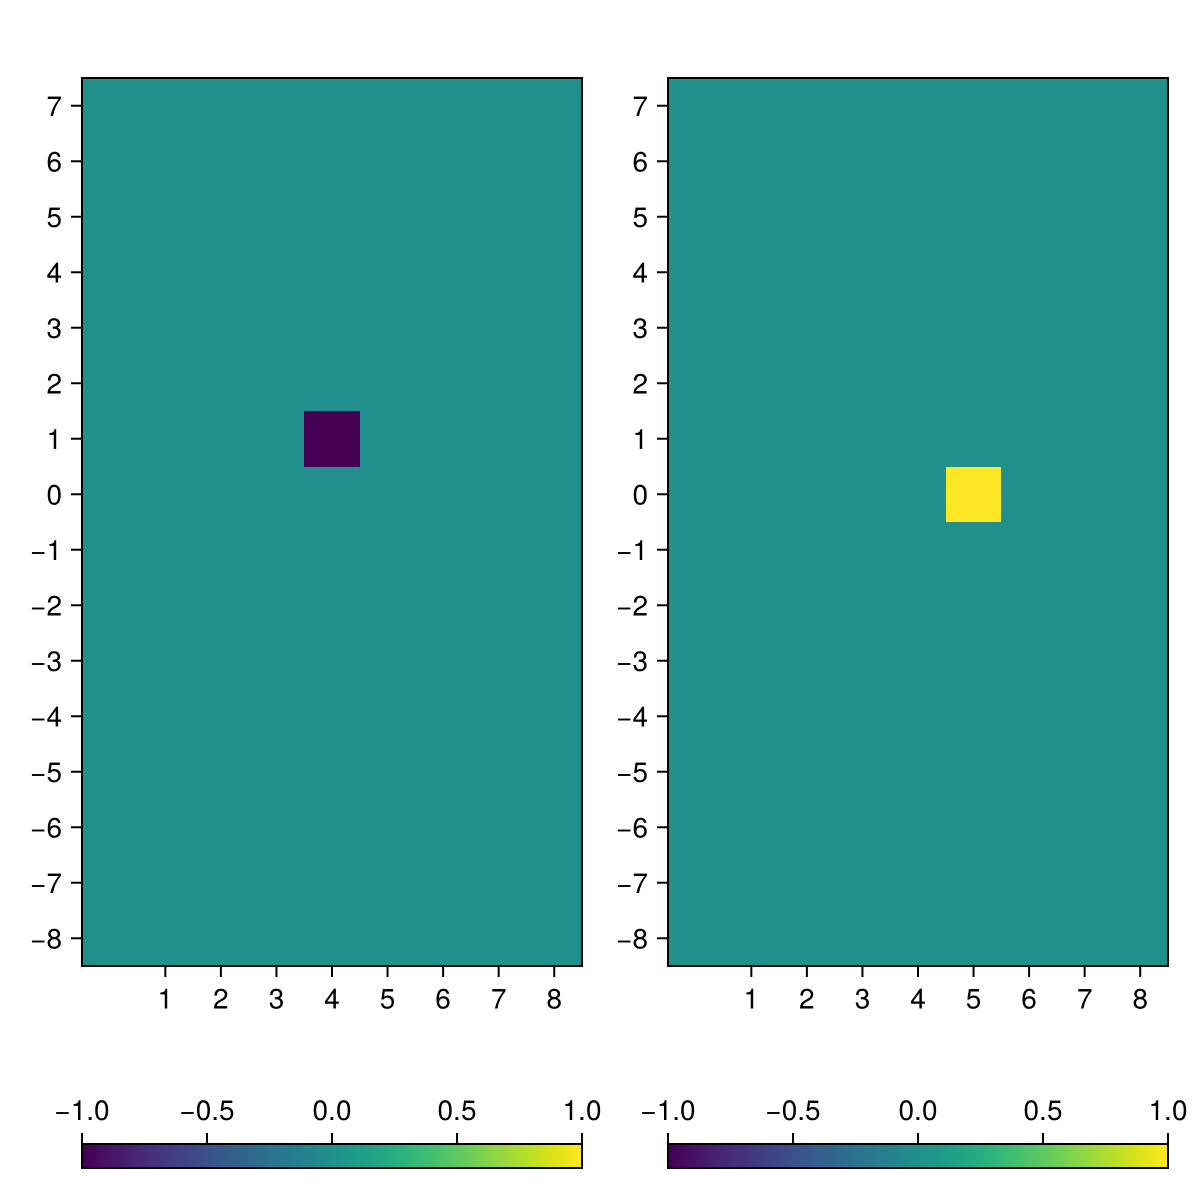

In [187]:
test_grid = TwoDGrid(nx=16, Lx=2π, T=Float32)
ψh = zeros(Complex{Float32}, test_grid.nkr, test_grid.nl)
ψ = zeros(Float32, test_grid.nx, test_grid.ny)
ψ .+= cos.( 4*test_grid.x .+  1*test_grid.y')
#ψ .+= cos.( 5*test_grid.x .+ -3*test_grid.y')
ψ .+= sin.( 5*test_grid.x .+  0*test_grid.y' .+ 0π/2)
mul!(ψh, test_grid.rfftplan, ψ)
ψh /= grid.nx
f = Figure(size=(600, 600))
ax1 = Axis(f[1, 1]; xticks=1:grid.nkr, yticks=-grid.nl:(grid.nl-1), aspect=DataAspect())
cf1 = heatmap!(ax1, Array(test_grid.kr)[:], fftshift(Array(test_grid.l)[:]), fftshift(real.(Array(ψh)), 2), colorrange=(-1, 1))
Colorbar(f[2, 1], cf1, vertical=false)
ax2 = Axis(f[1, 2]; xticks=1:grid.nkr, yticks=-grid.nl:(grid.nl-1), aspect=DataAspect())
cf2 = heatmap!(ax2, Array(test_grid.kr)[:], fftshift(Array(test_grid.l)[:]), fftshift(imag.(Array(ψh)), 2), colorrange=(-1, 1))
Colorbar(f[2, 2], cf2, vertical=false)
#heatmap(ψ)
f

In [21]:
Array(prob.timestepper.expLdt)

129×256×3×3 Array{ComplexF32, 4}:
[:, :, 1, 1] =
      1.0+0.0im       1.0+0.0im  …       1.0+0.0im       1.0+0.0im
 0.999999+0.0im  0.999999+0.0im     0.999999+0.0im  0.999999+0.0im
 0.999997+0.0im  0.999997+0.0im     0.999997+0.0im  0.999997+0.0im
 0.999993+0.0im  0.999993+0.0im     0.999993+0.0im  0.999993+0.0im
 0.999988+0.0im  0.999988+0.0im     0.999988+0.0im  0.999988+0.0im
 0.999981+0.0im  0.999981+0.0im  …  0.999981+0.0im  0.999981+0.0im
 0.999973+0.0im  0.999973+0.0im     0.999973+0.0im  0.999973+0.0im
 0.999963+0.0im  0.999963+0.0im     0.999963+0.0im  0.999963+0.0im
 0.999952+0.0im  0.999952+0.0im     0.999952+0.0im  0.999952+0.0im
 0.999939+0.0im  0.999939+0.0im     0.999939+0.0im  0.999939+0.0im
 0.999925+0.0im  0.999925+0.0im  …  0.999925+0.0im  0.999925+0.0im
 0.999909+0.0im  0.999909+0.0im     0.999909+0.0im  0.999909+0.0im
 0.999892+0.0im  0.999892+0.0im     0.999892+0.0im  0.999892+0.0im
         ⋮                       ⋱                          ⋮
  1.00239+0.0im   

In [74]:
vars = prob.vars
clock = prob.clock


0.0006393192294700216

In [81]:
maximum(vars.η)

0.0004136587764574625

In [80]:
1e-3

0.001